In [2]:
import pandas as pd

df = pd.read_csv('AI_Impact_on_Jobs_2030.csv')

print(df.head())
print(df.info())
print(df.describe())


             Job_Title  Average_Salary  Years_Experience Education_Level  \
0       Security Guard           45795                28        Master's   
1   Research Scientist          133355                20             PhD   
2  Construction Worker          146216                 2     High School   
3    Software Engineer          136530                13             PhD   
4    Financial Analyst           70397                22     High School   

   AI_Exposure_Index  Tech_Growth_Factor  Automation_Probability_2030  \
0               0.18                1.28                         0.85   
1               0.62                1.11                         0.05   
2               0.86                1.18                         0.81   
3               0.39                0.68                         0.60   
4               0.52                1.46                         0.64   

  Risk_Category  Skill_1  Skill_2  Skill_3  Skill_4  Skill_5  Skill_6  \
0          High     0.45     0.

In [3]:
df_filled = df.fillna(df.mean(numeric_only=True))


In [4]:
df.isna().sum()

,0
Job_Title,0
Average_Salary,0
Years_Experience,0
Education_Level,0
AI_Exposure_Index,0
Tech_Growth_Factor,0
Automation_Probability_2030,0
Risk_Category,0
Skill_1,0
Skill_2,0


In [5]:
from sklearn.preprocessing import LabelEncoder

df_enc = df.copy()

label_cols = ['Job_Title', 'Education_Level', 'Risk_Category']
le = LabelEncoder()

for col in label_cols:
    df_enc[col] = le.fit_transform(df_enc[col])


In [6]:
from sklearn.model_selection import train_test_split

X = df_enc.drop('Risk_Category', axis=1)
y = df_enc['Risk_Category']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


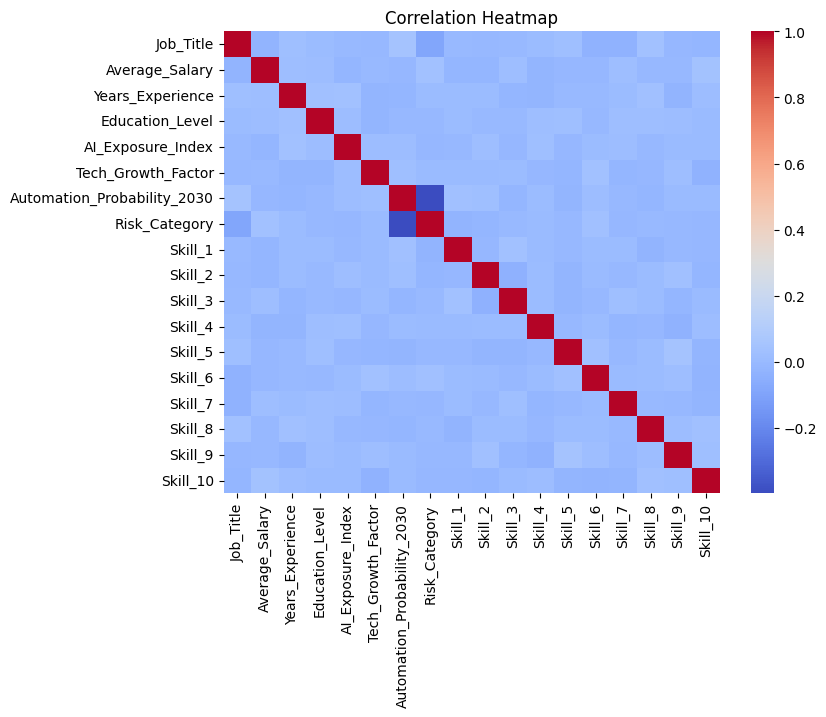

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(df_enc.corr(), cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


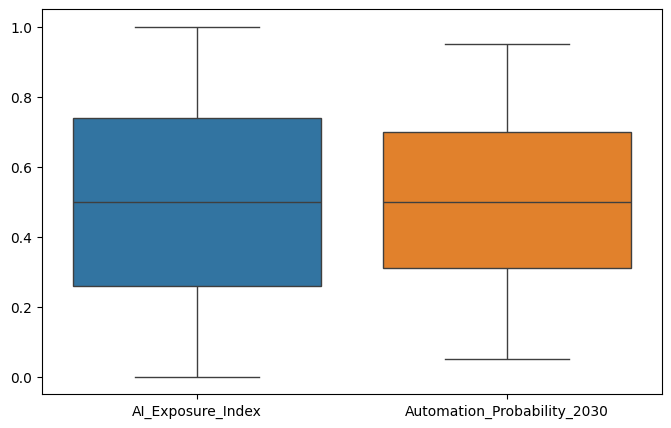

In [8]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df[['AI_Exposure_Index', 'Automation_Probability_2030']])
plt.show()


In [9]:
from scipy.stats import pearsonr

corr, p = pearsonr(df['AI_Exposure_Index'], df['Automation_Probability_2030'])
print("Correlation:", corr)
print("P-value:", p)


Correlation: 0.01431982285262542
P-value: 0.4330152726086762


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

pred_lr = logreg.predict(X_test)

print(classification_report(y_test, pred_lr))
print(confusion_matrix(y_test, pred_lr))


              precision    recall  f1-score   support

           0       0.87      0.62      0.72       167
           1       0.68      0.54      0.60       149
           2       0.63      0.81      0.71       284

    accuracy                           0.69       600
   macro avg       0.73      0.66      0.68       600
weighted avg       0.71      0.69      0.69       600

[[103   0  64]
 [  0  80  69]
 [ 15  38 231]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

pred_dt = dt.predict(X_test)

print(classification_report(y_test, pred_dt))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       149
           2       1.00      1.00      1.00       284

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=150)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print(classification_report(y_test, pred_rf))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       167
           1       1.00      1.00      1.00       149
           2       1.00      1.00      1.00       284

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600



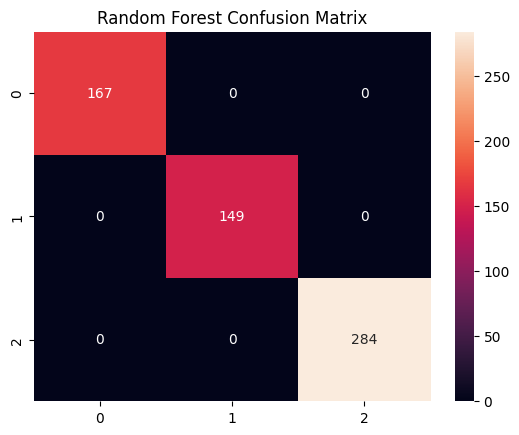

In [13]:
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d')
plt.title("Random Forest Confusion Matrix")
plt.show()


In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_enc)

df_enc['Cluster'] = clusters


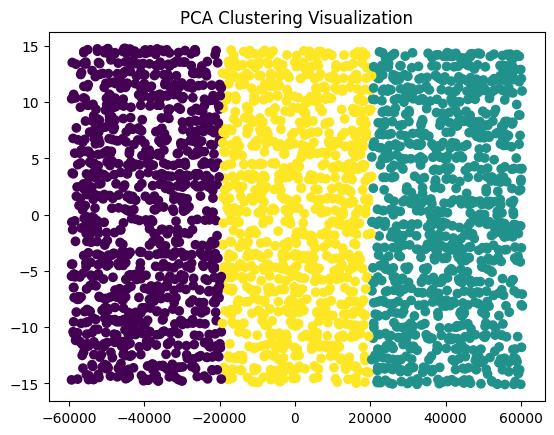

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_enc.drop('Cluster', axis=1))

plt.scatter(pca_data[:,0], pca_data[:,1], c=clusters)
plt.title("PCA Clustering Visualization")
plt.show()


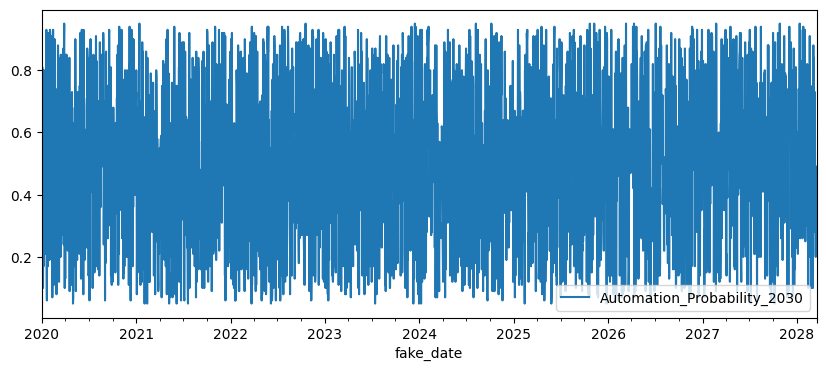

In [16]:
df['fake_date'] = pd.date_range(start="2020-01-01", periods=len(df))

df_ts = df[['fake_date', 'Automation_Probability_2030']]
df_ts = df_ts.set_index('fake_date')

df_ts.plot(figsize=(10,4))
plt.show()


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.2)


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4097 - loss: 3265.1277 - val_accuracy: 0.2313 - val_loss: 143.0329
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3797 - loss: 130.4966 - val_accuracy: 0.5042 - val_loss: 132.3820
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4054 - loss: 159.0931 - val_accuracy: 0.5042 - val_loss: 264.9160
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3987 - loss: 158.6578 - val_accuracy: 0.5042 - val_loss: 94.4490
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3866 - loss: 139.1095 - val_accuracy: 0.2646 - val_loss: 258.3010
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3646 - loss: 182.1578 - val_accuracy: 0.2313 - val_loss: 48.5140
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3663 - loss: 115.7640 - val_accuracy: 0.2313 - val_loss: 52.2196
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3717 - loss: 144.7425 - val_accuracy: 0

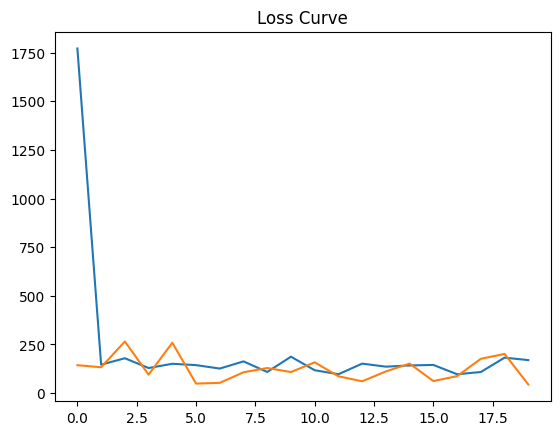

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.show()


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
job_vecs = tfidf.fit_transform(df['Job_Title'])

print(job_vecs.shape)


(3000, 31)


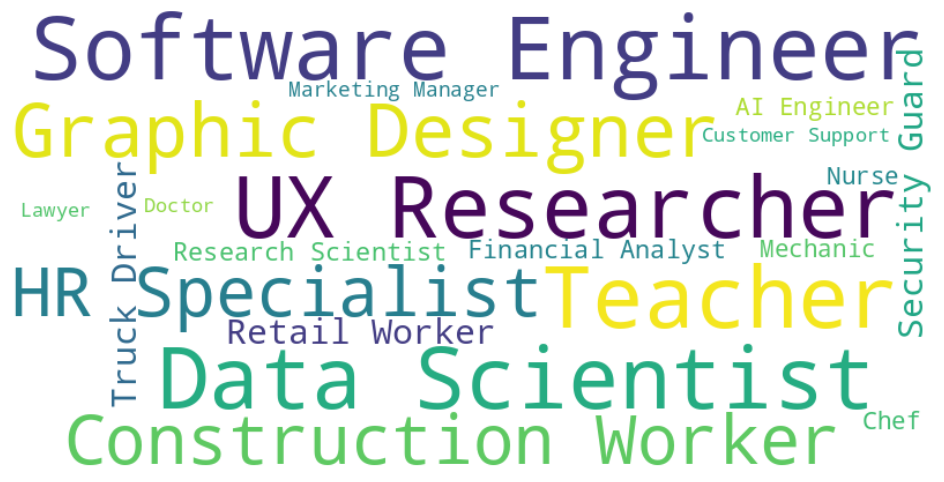

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_titles = " ".join(df['Job_Title'])

wc = WordCloud(width=800, height=400, background_color="white").generate(all_titles)

plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


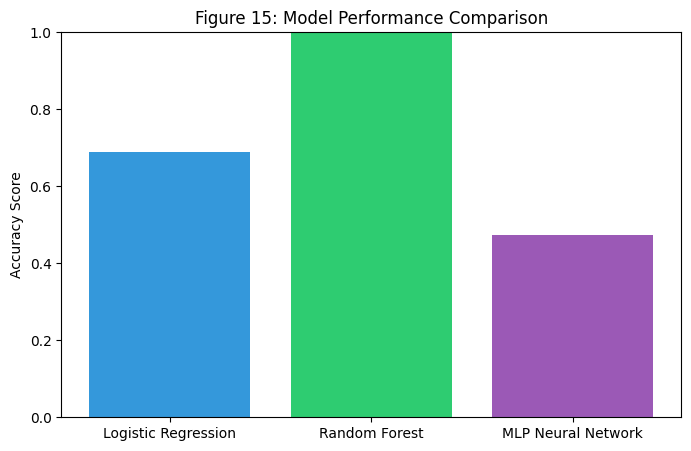

Accuracies:
Logistic Regression: 0.69
Random Forest: 1.0
MLP Neural Network: 0.47333333333333333


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv('AI_Impact_on_Jobs_2030.csv')

df_enc = df.copy()
cat_cols = df_enc.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    le = LabelEncoder()
    df_enc[col] = le.fit_transform(df_enc[col].astype(str))

target_col = 'Risk_Category' if 'Risk_Category' in df_enc.columns else df_enc.columns[-1]

X = df_enc.drop(columns=[target_col])
y = df_enc[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
acc_log = accuracy_score(y_test, log.predict(X_test))

rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(X_test))

mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)
acc_mlp = accuracy_score(y_test, mlp.predict(X_test))


accuracies = {
    "Logistic Regression": acc_log,
    "Random Forest": acc_rf,
    "MLP Neural Network": acc_mlp
}

plt.figure(figsize=(8,5))
plt.bar(accuracies.keys(), accuracies.values(), color=['#3498db','#2ecc71','#9b59b6'])
plt.title("Figure 15: Model Performance Comparison")
plt.ylabel("Accuracy Score")
plt.ylim(0, 1)
plt.show()

print("Accuracies:")
print("Logistic Regression:", acc_log)
print("Random Forest:", acc_rf)
print("MLP Neural Network:", acc_mlp)


In [23]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df = pd.read_csv('AI_Impact_on_Jobs_2030.csv')

df['Date'] = pd.date_range(start='2010-01-01', periods=len(df), freq='M')

target = "Automation_Probability_2030"

ts = df.set_index("Date")[target]
ts = ts.asfreq("M").fillna(method="ffill")


/tmp/ipython-input-4239709724.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df['Date'] = pd.date_range(start='2010-01-01', periods=len(df), freq='M')
/tmp/ipython-input-4239709724.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = ts.asfreq("M").fillna(method="ffill")
/tmp/ipython-input-4239709724.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.asfreq("M").fillna(method="ffill")


<Figure size 1200x800 with 0 Axes>

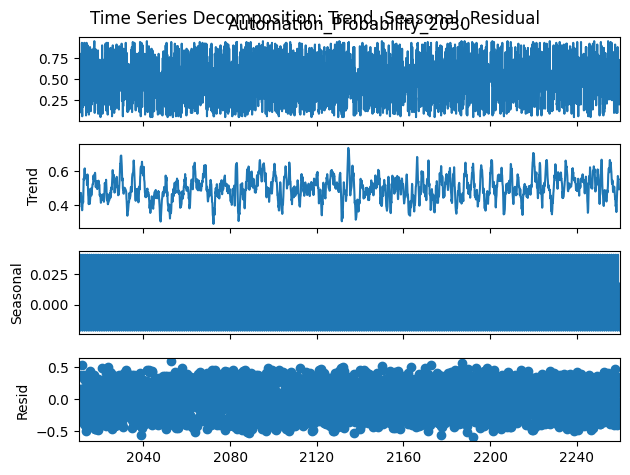

In [24]:
decomp = seasonal_decompose(ts, model='additive', period=12)

plt.figure(figsize=(12,8))
decomp.plot()
plt.suptitle("Time Series Decomposition: Trend, Seasonal, Residual")
plt.show()


ARIMA MAE: 0.20118599914604948
ARIMA RMSE: 0.2389203210702597


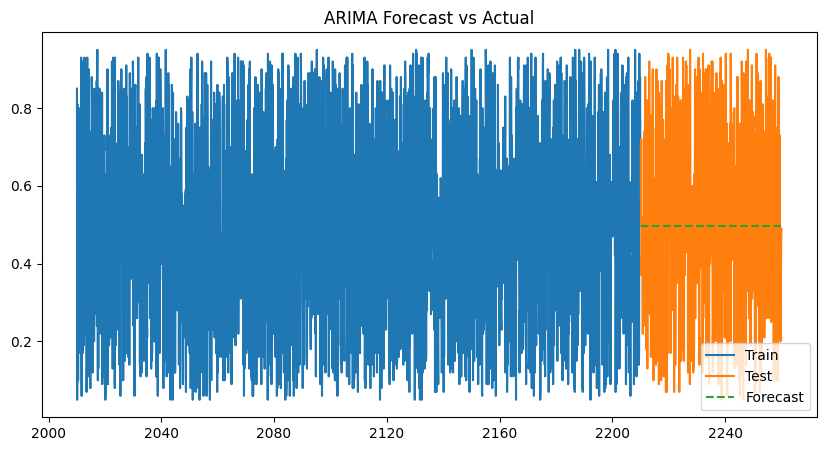

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(steps=len(test))

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print("ARIMA MAE:", mae)
print("ARIMA RMSE:", rmse)

plt.figure(figsize=(10,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(forecast, label="Forecast", linestyle='--')
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Prophet MAE: 0.20217037324821188
Prophet RMSE: 0.23902384247345923


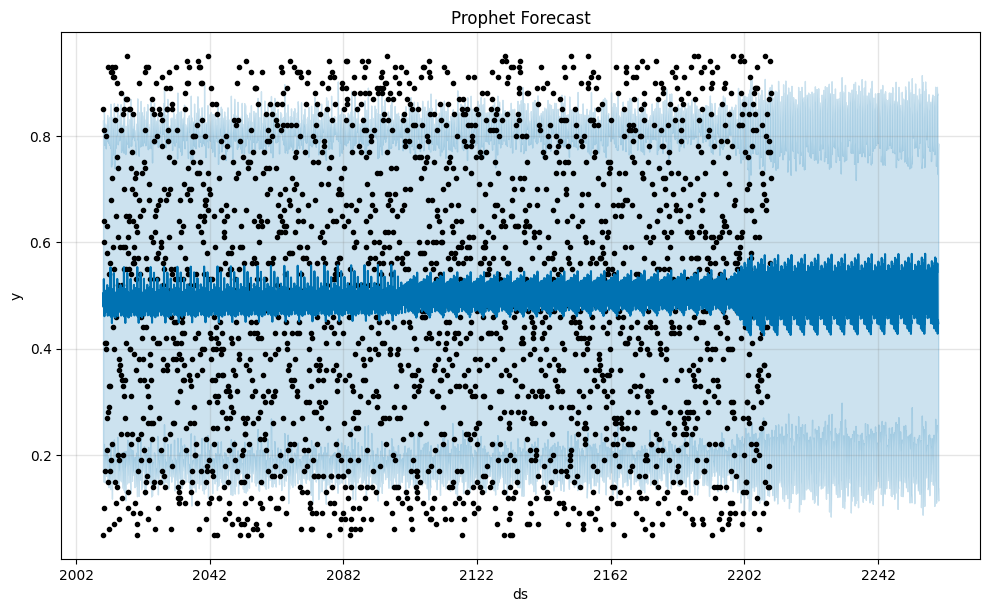

In [26]:
from prophet import Prophet

df_prophet = df[['Date', target]].rename(columns={'Date':'ds', target:'y'})

train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

model_p = Prophet()
model_p.fit(train)

future = model_p.make_future_dataframe(periods=len(test), freq='M')
forecast_p = model_p.predict(future)

pred_p = forecast_p.iloc[-len(test):]['yhat'].values

mae_p = mean_absolute_error(test['y'], pred_p)
rmse_p = np.sqrt(mean_squared_error(test['y'], pred_p))

print("Prophet MAE:", mae_p)
print("Prophet RMSE:", rmse_p)

model_p.plot(forecast_p)
plt.title("Prophet Forecast")
plt.show()
